In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import *
import h5py
h5py.enable_ipython_completer()

In [2]:
from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.syndat.MMDA import generate
import ATARI.atari_io.hdf5 as io
from ATARI.theory.xs import SLBW


In [3]:
# syndat.particle_pair()

In [4]:
%matplotlib widget

In [5]:
ac = 0.81271  # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider


Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={})


In [6]:
from scipy import integrate
from ATARI.PiTFAll.sample_case import fine_egrid
from ATARI.theory.scattering_params import FofE_recursive
from ATARI.sammy_interface.sammy_interface import solve_bayes
from ATARI.utils.stats import chi2_val


def gn2G(row):
    S, P, phi, k = FofE_recursive([row.E], Ta_pair.ac, Ta_pair.M, Ta_pair.m, row.lwave)
    Gnx = 2*np.sum(P)*row.gnx2
    return Gnx.item()

def G2gn(row):
    S, P, phi, k = FofE_recursive([row.E], Ta_pair.ac, Ta_pair.M, Ta_pair.m, row.lwave)
    gnx2 = row.Gnx/2/np.sum(P)
    return gnx2.item()

spin_groups = [ (3.0,1,0)] # , (4.0,1,[0]) ]
average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':8.79, '4.0':4.99},
                                    'Gg'    :   {'3.0':64.0, '4.0':64.0},
                                    'gn2'    :   {'3.0':46.4, '4.0':35.5}  })



     E    J  chs  lwave  J_ID  gnx2   Gg        Gtot
0  570  3.0  1.0    0.0   1.0   100  750  758.478159


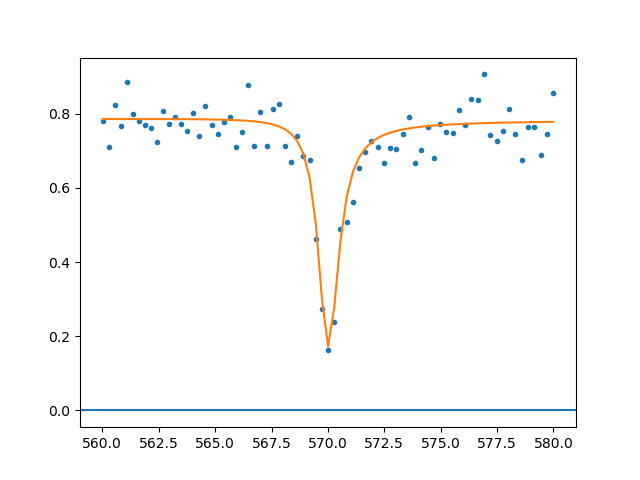

In [7]:
# create an energy domain, min/max
E_min_max = [560, 580]
# E_min_max =[3.5, 2550]

### or just give the min/max and the experiment object will do the above
energy_grid = E_min_max

input_options = {'Add Noise': True,
                'Calculate Covariance': True,
                'Compression Points':[],
                'Grouping Factors':None}

experiment_parameters = {'bw': {'val':0.0256,    'unc'   :   0}}

# initialize experimental setup
exp = Experiment(energy_grid, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)

# Gtot = 2.0
# Gnx = 0.3*Gtot
# resonance_ladder = pd.DataFrame({'E':[570], 'J':[3.0], 'chs':[1.0], 'lwave':[0.0], 'J_ID':[1.0], 'Gnx':Gnx})
# resonance_ladder['gnx2'] = resonance_ladder.apply(lambda row: G2gn(row), axis=1) #G2gn(testres) #
# resonance_ladder['Gg'] = Gtot-Gnx
# resonance_ladder['gnx2'] = resonance_ladder['gnx2']*1e3
# resonance_ladder['Gg'] = resonance_ladder['Gg']*1e3
# resonance_ladder['Gnx'] = resonance_ladder['Gnx']*1e3

# resonance_ladder = Ta_pair.sample_resonance_ladder(E_min_max, spin_groups, average_parameters, False)
resonance_ladder = pd.DataFrame({'E':[570], 'J':[3.0], 'chs':[1.0], 'lwave':[0.0], 'J_ID':[1.0], 'gnx2':[100], 'Gg':[750]})
Gnx = resonance_ladder.apply(lambda row: gn2G(row), axis=1)
resonance_ladder['Gtot'] = Gnx + resonance_ladder['Gg']

print(resonance_ladder)

true, _, _ = SLBW(exp.energy_domain, Ta_pair, resonance_ladder)
df_true = pd.DataFrame({'E':exp.energy_domain, 'theo_trans':np.exp(-exp.redpar.val.n*true)})

exp.run(df_true)

figure()
plot(exp.trans.E, exp.trans.exp_trans, '.')
plot(exp.theo.E, exp.theo.theo_trans)
axhline(0)

## Create initial feature matrix A and verify

Need to come back to this and fix the slight difference between sammy, syndat, and this matrix implementation

In [8]:
import scipy.stats as sts

Gnx_avg = average_parameters['gn2']['3.0']/12.5
Gtot_avg = Gnx_avg + average_parameters['Gg']['3.0']
max_Gtot = sts.chi2.ppf(0.99, 1, loc=0, scale=Gnx_avg)/1 + average_parameters['Gg']['3.0']
min_Gtot = average_parameters['Gg']['3.0']
max_Gtot = max_Gtot*1e-3
min_Gtot = min_Gtot*1e-3
max_Gtot = 0.8
min_Gtot = 0.7
print(max_Gtot)
print(min_Gtot)

max_Elam = max(energy_grid) + Gtot_avg/10e3
min_Elam = min(energy_grid) - Gtot_avg/10e3
print(max_Elam)
print(min_Elam)


Elam_features = np.arange(min_Elam, max_Elam, 1e-1)
Gtot_features = np.arange(min_Gtot, max_Gtot, 1e-2)
print(len(Elam_features))
print(len(Gtot_features))

0.8
0.7
580.0067712
559.9932288
201
11


In [9]:
Gtot_features

array([0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 ])

In [10]:
from ATARI.theory import scattering_params

# Elam_features = [565, 569, 570, 571, 575]
# Gtot_features = [.7585]

energy = np.sort(exp.energy_domain)
number_of_resonances = len(Elam_features)*len(Gtot_features)
Resonance_Matrix = np.zeros((len(energy), number_of_resonances))

E = energy
lwave = 0
S, P, phi, k = FofE_recursive(E, Ta_pair.ac, Ta_pair.M, Ta_pair.m, lwave)
g = scattering_params.gstat(3.0, Ta_pair.I, Ta_pair.i)
kinematic_constant = (4*np.pi*g/k**2)
potential_scattering = kinematic_constant * np.sin(phi)**2

solution = np.zeros((number_of_resonances,1))

for iElam, Elam in enumerate(Elam_features):
    for iGtot, Gtot in enumerate(Gtot_features):

        SElam, PElam, phiElam, kElam = FofE_recursive([Elam], Ta_pair.ac, Ta_pair.M, Ta_pair.m, lwave)
        PPElam = P/PElam
        A_column =  kinematic_constant * Gtot * ( Gtot*PPElam**2*np.cos(2*phi) /4 /((Elam-E)**2+(Gtot*PPElam/2)**2) 
                                                -(Elam-E)*PPElam*np.sin(2*phi) /2 /((Elam-E)**2+(Gtot*PPElam/2)**2) )  

        vertical_index = (iElam)*len(Gtot_features) + iGtot
        # print(vertical_index)
        Resonance_Matrix[:, vertical_index] = A_column

        # ### get solution
        # if np.any(np.round(resonance_ladder.E) == np.round(Elam)):
        #     solres = resonance_ladder[np.round(resonance_ladder.E) == np.round(Elam)]
        #     solres['Gnx'] = solres.apply(lambda row: gn2G(row), axis=1)
        #     if np.round((solres['Gnx']+solres['Gg']).item()) == np.round(Gtot*1e3):
        #         solution[vertical_index] = solres['Gnx']/(solres['Gnx'] + solres['Gg'])
        #     else:
        #         pass
        # else:
        #     pass


In [11]:
### Important to sert values!
CovT = np.flip(exp.CovT)
exp.trans.sort_values('E', inplace=True)
exp.theo.sort_values('E', inplace=True)

### Convert experimental transmission to experimental cross section

This is done s.t. we can solve the linear algebra optimization problem. It is not linear in transmission space.

In [12]:
from scipy.linalg import block_diag
from numpy.linalg import inv

xs_theo = (-1/exp.redpar.val.n)*np.log(exp.theo.theo_trans)
xs_exp = (-1/exp.redpar.val.n)*np.log(exp.trans.exp_trans)

exp.theo['theo_xs'] = xs_theo
exp.trans['exp_xs'] = xs_exp

dXi_dn = (1/exp.redpar.val.n**2) * np.log(exp.theo.theo_trans)
dXi_dT = (-1/exp.redpar.val.n) * (1/exp.theo.theo_trans)

Jac = np.vstack((np.diag(dXi_dT),dXi_dn))
Cov = block_diag(CovT,exp.redpar.unc.n**2)
CovXS = Jac.T @ Cov @ Jac

Lxs = np.linalg.cholesky(inv(CovXS))
np.max(Lxs@Lxs.T - inv(CovXS))

4.440892098500626e-16

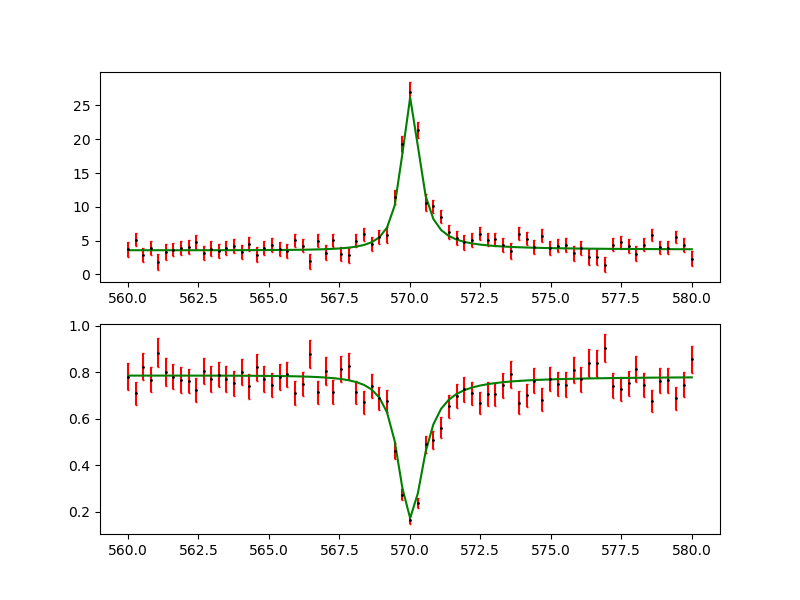

In [13]:
fig, axes = subplots(2,1, figsize=(8,6))
axes[0].errorbar(exp.trans.E, exp.trans.exp_xs, yerr=np.sqrt(np.diag(CovXS)), fmt='.', ecolor='r', color='k', capsize=1, ms=2)
axes[0].plot(exp.theo.E, exp.theo.theo_xs, color='g')
# axes[0].plot(E, xs_tot, color='b', alpha=0.5, lw=1,label='init')
# axes[0].plot(E, Resonance_Matrix@solution+potential_scattering, color='b', alpha=0.5, lw=1,label='init')
# axes[0].set_yscale('log')

axes[1].errorbar(exp.trans.E, exp.trans.exp_trans, yerr=np.sqrt(np.diag(CovT)), fmt='.', ecolor='r', color='k', capsize=1, ms=2)
axes[1].plot(exp.theo.E, exp.theo.theo_trans, color='g')
# axes[1].plot(E, trans, color='b', alpha=0.5, lw=1,label='init')


In [14]:
from scipy.optimize import lsq_linear

# Fold Covariance into A and b, and potential scattering into b
# b = Lxs.T @ (np.array(exp.trans.exp_xs) - potential_scattering.flatten())
# A = Lxs.T @ Resonance_Matrix
b = (np.array(exp.trans.exp_xs)-potential_scattering).flatten()
A = Resonance_Matrix

res = lsq_linear(A, b, bounds=(0, 1), 
                                    lsmr_tol='auto', 
                                    lsq_solver='lsmr',
                                    max_iter = 500, 
                                    verbose=1)

print((Resonance_Matrix@res.x-(np.array(exp.trans.exp_xs)-potential_scattering).flatten()) @ inv(CovXS) @ (Resonance_Matrix@res.x-(np.array(exp.trans.exp_xs)-potential_scattering).flatten()).T)
print( (A@res.x-b) @ (A@res.x-b).T )
# print(res.x)

The maximum number of iterations is exceeded.
Number of iterations 500, initial cost 2.2325e+10, final cost 2.5935e+01, first-order optimality 1.43e+00.
47.84240115235628
51.86931914641686


In [15]:
## Cholesky decomposition test
# A = np.array([[1,2],[1,2]])
# b = np.array([1,1])
# x = np.array([1,1])
# C = np.array([[2,1],[1,2]])
# L = np.linalg.cholesky(inv(C))
# Ap = L.T@A
# bp = L.T@b

# print((Ap@x-bp)@(Ap@x-bp).T)
# print((A@x-b)@inv(C)@(A@x-b).T)
# (Ap@x-bp)@(Ap@x-bp).T == (A@x-b)@inv(C)@(A@x-b).T

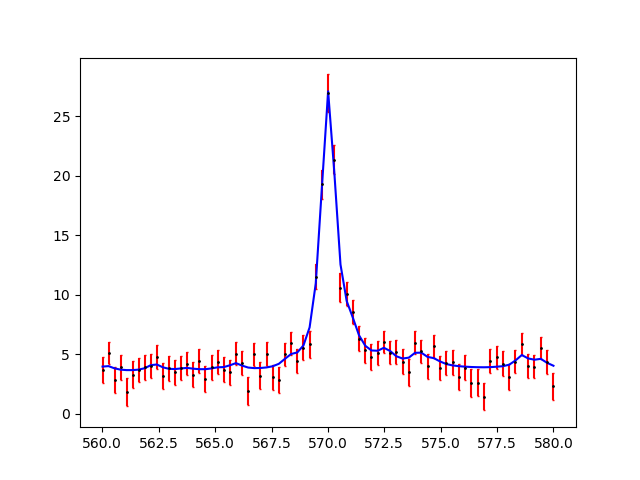

In [16]:
figure()
errorbar(exp.trans.E, exp.trans.exp_xs, yerr=np.sqrt(np.diag(CovXS)), fmt='.', ecolor='r', color='k', capsize=1, ms=2)
# plot(exp.theo.E, exp.theo.theo_xs, color='g')
# plot(E, b+potential_scattering.flatten(), color='y')
plot(E, Resonance_Matrix@res.x+potential_scattering.flatten(), color='b')
# xs = inv(Lxs.T) @ ((A@res.x) + Lxs.T@potential_scattering.flatten())
# plot(E, xs, color='b', alpha=0.5, lw=2,label='sol')


# for each in Elam_features:
#     axvline(each, color='k', lw=1)
# ylim([-1,100])

### Now solve it with bounds to mimic lasso

0.01671391018123243


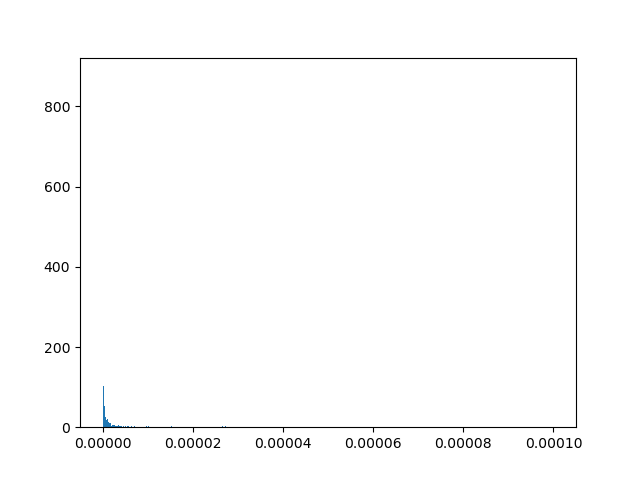

In [17]:

np.shape(np.repeat(np.atleast_2d(A[:,-1]).T, np.shape(A[:,0:-1])[1], axis=1))
figure()
bins = hist(res.x, bins=1000, range=(1e-10, 1e-4))

print(np.sum(res.x))


In [18]:
# add a row of all ones to get the sum of weights
maxres = np.sum(res.x)

# # Fold Covariance into A and b, and potential scattering into b
b = (np.array(exp.trans.exp_xs) - potential_scattering.flatten())
A = Resonance_Matrix
# b = Lxs.T @ (np.array(exp.trans.exp_xs) - potential_scattering.flatten())
# A = Lxs.T @ Resonance_Matrix

last_sig = A[:,-1]
last_sig_mat = np.repeat(np.atleast_2d(last_sig).T, np.shape(A[:,0:-1])[1], axis=1)
Anew = A[:,0:-1] - last_sig_mat
bnew = b - last_sig*maxres

res_new = lsq_linear(Anew, bnew, bounds=(np.zeros(np.shape(Anew)[1]), np.ones(np.shape(Anew)[1])), 
                                    lsmr_tol='auto', 
                                    lsq_solver='lsmr',
                                    max_iter = 500, 
                                    verbose=1)

print( (A@res.x-b) @ (A@res.x-b).T )
print( (Anew@res_new.x-bnew) @ (Anew@res_new.x-bnew).T )

last_x = maxres - np.sum(res_new.x)
solution = np.append(res_new.x, last_x)
print(solution)

The maximum number of iterations is exceeded.
Number of iterations 500, initial cost 1.4998e+11, final cost 4.2503e+01, first-order optimality 3.87e+01.
51.86931914641686
85.00660620115313
[ 4.23278465e-58  4.92660717e-58  5.70437303e-58 ...  7.43643447e-02
  8.71144757e-02 -4.97686504e-01]


0.01671391018123243
0.514400414023124


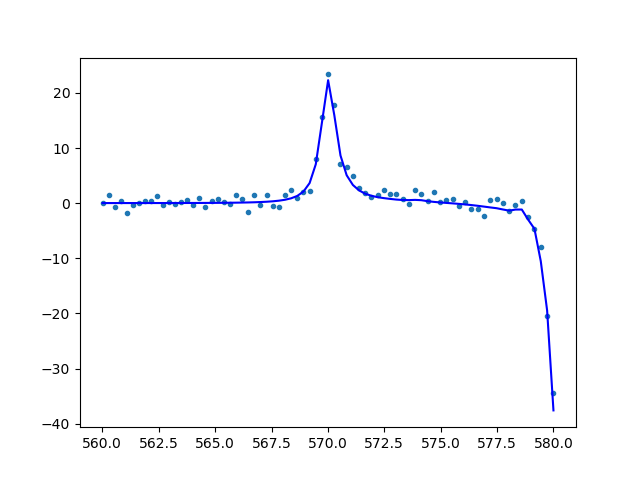

In [19]:
figure()
# errorbar(exp.trans.E, exp.trans.exp_xs, yerr=np.sqrt(np.diag(CovXS)), fmt='.', ecolor='r', color='k', capsize=1, ms=2)
# plot(exp.theo.E, exp.theo.theo_xs, color='g')
# plot(E,Resonance_Matrix@solution+potential_scattering.flatten(), color='b')

plot(E, bnew, '.')
plot(E, Anew @ res_new.x , color='b')

# plot(E, bnew-last_sig*maxres, '.')
# plot(E, b, '.')
# plot(E, np.sum(A[:,:], axis=1))
# plot(E, (Anew@res_new.x)+last_sig*maxres , color='b')

# x = np.append(res_new.x, maxres-np.sum(res_new.x))
# plot(E, (A@x)-(last_sig*maxres) , color='b', alpha=0.5, lw=2,label='sol')

print(np.sum(res.x))
print(np.sum(res_new.x))

### Now loop over grid of max res